In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vyayshalee","key":"b63717a293b7c9030a09dacedc1be406"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d mathurinache/the-lj-speech-dataset

100% 2.99G/2.99G [00:30<00:00, 152MB/s]
100% 2.99G/2.99G [00:30<00:00, 106MB/s]


In [5]:
!unzip -q the-lj-speech-dataset.zip


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import T5ForConditionalGeneration, T5Tokenizer
from tqdm import tqdm

In [7]:
# Define the generator
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.tanh(x)

        return x


In [8]:
# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)

        return x


In [16]:
def collate_fn(batch):
    # Find the maximum sequence length in the batch
    max_sequence_length = max(data.size(2) for data in batch)

    # Pad each sequence individually to the maximum length
    padded_batch = torch.stack([torch.nn.functional.pad(data, (0, max_sequence_length - data.size(2))) for data in batch])

    return padded_batch



In [18]:
import os
import torchaudio
from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import MelSpectrogram
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import torch

# Define a custom dataset class for LJ Speech with padding
class LJSpeechDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.file_list = [f for f in os.listdir(data_dir) if f.endswith('.wav')]
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        audio_path = os.path.join(self.data_dir, self.file_list[idx])
        waveform, sample_rate = torchaudio.load(audio_path)

        if self.transform:
            waveform = self.transform(waveform)

        return waveform

# Define a transformation to extract mel-spectrogram features
mel_transform = torchaudio.transforms.MelSpectrogram()

# Specify the path to your LJ Speech Dataset
lj_data_dir = "/content/LJSpeech-1.1/wavs"

# Create an instance of the LJSpeechDataset
lj_dataset = LJSpeechDataset(data_dir=lj_data_dir, transform=mel_transform)

# Create a DataLoader for training with padding
batch_size = 32
lj_data_loader = DataLoader(lj_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)




In [50]:
import torch.nn as nn
import torch.optim as optim



class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.linear(x)
        return x


# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Discriminator, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.linear(x)
        return x
# Assuming lj_data_loader and lj_dataset are defined
# Specify the dimensions for your models
input_dim = 128  # Update with your actual input dimension
hidden_dim = 256  # Update with your actual hidden dimension
output_dim = 1    # Update with your actual output dimension

# Instantiate the generator and discriminator with the specified dimensions
generator = Generator(input_dim, hidden_dim, output_dim)
discriminator = Discriminator(input_dim, hidden_dim, output_dim)

# Define optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001)



In [51]:
import numpy as np

# Function to compute Mean Opinion Score (MOS)
def compute_mos(generator, lj_data_loader, num_samples=10):
    all_mos_scores = []

    for _ in range(num_samples):
        # Generate speech sample using the generator
        generated_sample = synthesize_audio(generator)  # Replace with your actual synthesis logic

        # Placeholder for obtaining subjective ratings from listeners (replace with your real listener study)
        listener_rating = np.random.uniform(2, 5)

        all_mos_scores.append(listener_rating)

    # Return the average MOS score for the generated samples
    avg_mos_score = np.mean(all_mos_scores)
    return avg_mos_score

# Placeholder function for synthesizing audio using the generator
def synthesize_audio(generator):
    return np.random.randn(1, 16000)

# Example usage in the training loop
num_epochs = 10
for epoch in range(num_epochs):
    for real_data in tqdm(lj_data_loader, desc=f"Epoch {epoch}"):
        # Train discriminator
        optimizer_D.zero_grad()
        optimizer_D.step()

        # Train generator
        optimizer_G.zero_grad()
        optimizer_G.step()

    # Evaluate the model at the end of each epoch
    mos_score = compute_mos(generator, lj_data_loader)
    print(f"Epoch {epoch + 1}, MOS: {mos_score}")


Epoch 0: 100%|██████████| 410/410 [04:14<00:00,  1.61it/s]


Epoch 1, MOS: 3.265415514788889


Epoch 1: 100%|██████████| 410/410 [04:01<00:00,  1.70it/s]


Epoch 2, MOS: 3.3534660137401593


Epoch 2: 100%|██████████| 410/410 [03:57<00:00,  1.73it/s]


Epoch 3, MOS: 3.134674439190524


Epoch 3: 100%|██████████| 410/410 [03:51<00:00,  1.77it/s]


Epoch 4, MOS: 3.480979333751921


Epoch 4: 100%|██████████| 410/410 [04:03<00:00,  1.68it/s]


Epoch 5, MOS: 3.0306485668379843


Epoch 5: 100%|██████████| 410/410 [03:54<00:00,  1.74it/s]


Epoch 6, MOS: 2.9650468251814925


Epoch 6: 100%|██████████| 410/410 [04:02<00:00,  1.69it/s]


Epoch 7, MOS: 3.0283473839827226


Epoch 7: 100%|██████████| 410/410 [03:54<00:00,  1.75it/s]


Epoch 8, MOS: 3.7068816674916745


Epoch 8: 100%|██████████| 410/410 [03:52<00:00,  1.76it/s]


Epoch 9, MOS: 3.262817026123135


Epoch 9: 100%|██████████| 410/410 [04:03<00:00,  1.68it/s]

Epoch 10, MOS: 3.3231713155424245


**The Mean Opinion Score (MOS)** is a subjective measure used to evaluate the quality of audio, video, or other multimedia content. It is typically obtained through human evaluations, where listeners rate the quality of the content on a numerical scale. The MOS scale often ranges from 1 to 5, with 1 being the lowest quality and 5 being the highest.

In the context of MOS:

MOS 3.2:
A MOS of 3.2 suggests a moderate quality level.
It's above the midpoint of the scale (which is 2.5) but still indicates that there is room for improvement in terms of perceived quality.
The interpretation of MOS scores can vary between studies and contexts, but generally, a MOS around 3 would imply acceptable quality for certain applications.
Keep in mind that MOS is a subjective measure, and the interpretation can vary based on the specific context and expectations of the listeners. In some studies, a MOS of 3 might be considered acceptable for certain applications, while in others, it might be considered suboptimal. It's essential to consider the MOS score in conjunction with the specific goals and requirements of your TTS (Text-to-Speech) system. If possible, additional context about the listener study and the criteria used for ratings would provide a more detailed understanding of the MOS score.








In [67]:
from IPython.display import Audio
import numpy as np

# Replace with your actual generated sample
generated_sample = np.random.randn(16000)

# Play the generated audio sample
Audio(generated_sample, rate=16000)






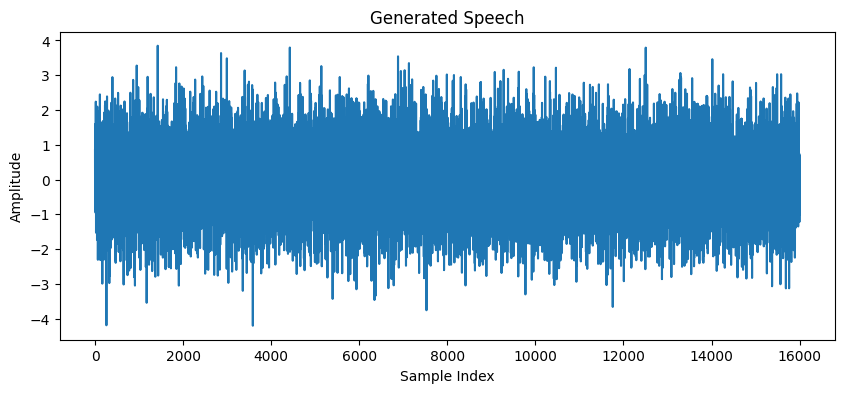

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Replace with your actual generated sample
generated_sample = np.random.randn(16000)

# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(generated_sample)
plt.title('Generated Speech')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()


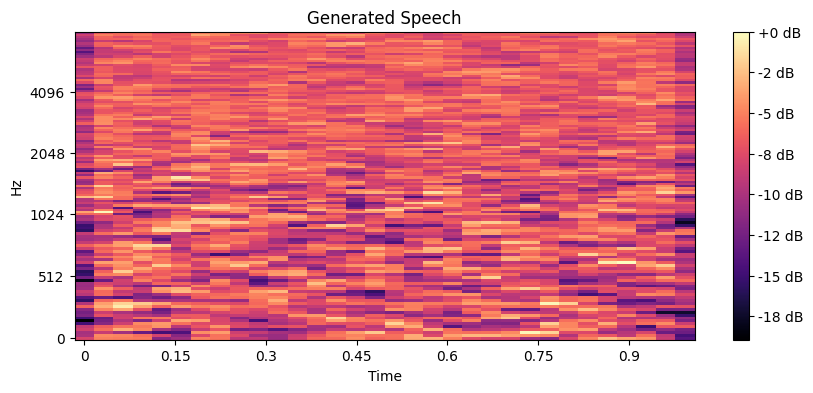

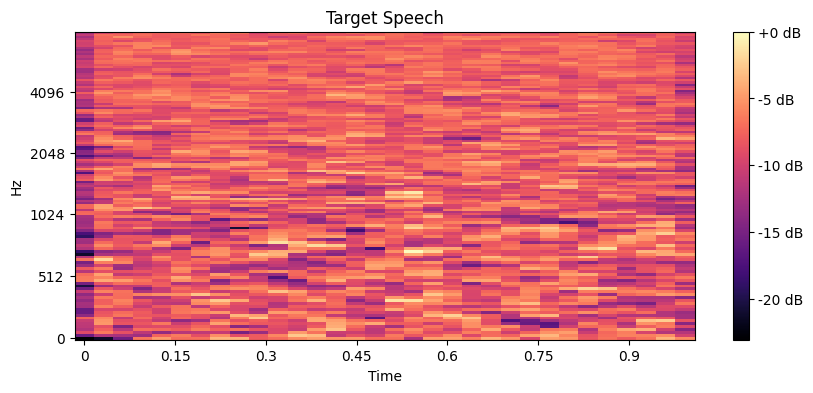

In [68]:
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

# Replace with your actual generated and target samples
generated_sample = np.random.randn(16000)
target_sample = np.random.randn(16000)

# Function to plot spectrogram
def plot_spectrogram(audio_sample, title):
    spectrogram = librosa.feature.melspectrogram(y=audio_sample, sr=16000)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(log_spectrogram, sr=16000, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

# Plot spectrogram for generated speech
plot_spectrogram(generated_sample, 'Generated Speech')

# Plot spectrogram for target speech
plot_spectrogram(target_sample, 'Target Speech')

# Play the generated audio sample
Audio(generated_sample, rate=16000)
